In [10]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-7build1).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge                                                          1 file, 77912192 bytes (75 MiB)

Extracting archive: /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
--
Path = /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      3% - train.t                7% - train.t               11% - train.t               14% - train.t               18% 

#   Bibliotecas

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes
import joblib  
import pickle

In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer #aplicação de dummy

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [3]:
#Pré processamento de texto

import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#import de funções do arquivo pre_processamento

from pre_processamento import pre_processamento

In [5]:
# Modelo a ser testado

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, Concatenate, Dropout, Reshape, Conv1D
from keras.layers import BatchNormalization, Activation, Flatten, MaxPooling1D
from keras.models import Model
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [6]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [7]:
#análises de desempenho

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# train = pd.read_pickle("train.pkl") 
train = pd.read_csv('train.tsv', sep = '\t')
test = pd.read_csv('test.tsv', sep = '\t')

In [12]:
train,test = pre_processamento(train,test)

#   Funções para Feature engineering

In [13]:
#Função pra juntar as colunas de texto em uma só
def textcolumns(df):

      #Preenchendo valores nulos com espaço em branco.
 
    
    df['name'].fillna(' ', inplace=True)
    df['brand_name'].fillna(' ', inplace=True)
    df['item_description'].fillna(' ', inplace=True)                
       

    #concatenando                              
    df["item_description"] =  df["name"]+" "+df["brand_name"]+" "+ df["item_description"]
    
    #convertendo string
    df["item_description"] = df["item_description"].astype(str)
                                 
                            
    #Removendo colunas que não serão usadas no modelo
    df = df.drop([  "name",
                    "brand_name",
                    "category_name",
                    "stock",
                    "datetime_month",
                    "datetime_year"   ], axis = 1)
                    
    return df



In [14]:
   #Função para "separação" de palavras, ex: Can't -> can not, objetivo de facilitar a limpeza, aonde não serão criadas duas palavras para cant/can not.
    # Será feito para diversas palavras com a mesma condição.
def text_clean(phrase):

    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = re.sub('https?://\S+| www.\S+', ' ', phrase) #Remoção de qualquer site que possa ter no nosso dataset
    phrase = re.sub("[^a-zA-Z0-9' \n\.]", ' ', phrase)  #excluindo tudo o que não for letra e numero.
    phrase = re.sub(r'([a-z0-9])\1{2,}', " ", phrase) #retirando letras repetidas mais de 2 vezes seguidas ex: "ele vaaai" -> "ele vai"
    phrase = re.sub(r'\s+[0-9]{3,}\s+', " ", phrase)  # removendo numeros muito grandes com 3 digitos ou mais
    phrase = re.sub(r'\s+([a-zA-Z])\1{1,}\s+', " ", phrase) #removendo letras repetidas isoladas ex: ele zz vai -> ele vai
    phrase= re.sub(r'[^\w\s]', '', phrase)
    
    
    phrase = re.sub(' +', ' ', phrase) #exclusão de espaços extras, ex: "eu    vou" -> "eu vou"

    phrase = phrase.lower() #passando para letra minúscula.

   
    return phrase
    

In [15]:
def stemming(text):
    porter = PorterStemmer()
    stop_words = stopwords.words('english')
    
    result=[]
    for word in text:
        if word not in stop_words:
            result.append(porter.stem(word))
    return result

In [16]:
def vectorize_data(df, vec=None):
    """
    Função para vetorizar a coluna item_description e salvar o fit

    input: df escolhido 
           vec = None para gerar um vetorizador
           caso já tenha sido feito o fit, passa-lo no parametro vec

    output: coluna vetorizada e o fit salvo para utiliza-lo
    
    """
    if vec==None:
        vec = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
        vec.fit(df["item_description"])
    tfid_data = vec.transform(df["item_description"])
    return tfid_data, vec

In [17]:
def onehot_data(df, ohe=None):

    """
    Função para one hot enconde nas colunas e salvar o fit

    input: df escolhido 
           ohe = None para gerar um fit
           caso já tenha sido feito o fit, passa-lo no parametro ohe

    output: matriz e o fit salvo para utiliza-lo
    
    """
    if ohe==None:
        ohe = OneHotEncoder(handle_unknown="ignore")
        ohe.fit(df[["item_condition_id",   
                   "shipping",
                   "sub1_cat",
                   "sub2_cat"]])

    ohe_data = ohe.transform(df[["item_condition_id",   
                                "shipping",
                                "sub1_cat",
                                "sub2_cat"]])

    return ohe_data, ohe

In [18]:
#função para juntar a vetorização do tfidf e a matriz do onehotencoder, retorna uma matriz.

def stack(vec, ohe):
    xstack = (hstack([vec, ohe],format='csr'))
    xstack.sort_indices()

    return xstack

#   Pipeline de pré-processamento

In [19]:
'''Função de pipeline para o pré processamento

    input: O df à ser pré-processado. 
           Para gerar um fit do tfidf e do onehot enconder, manter vec e ohe = None.
           Para usar como transform, passar os fit gerados nos parametros vec e ohe.
    
    Output: df = Retorna o df pré processado, 
            vec_data = matriz gerada no vectorizer
            vec = fit salvo do vectorizer
            ohe_data = matriz gerada pelo one hot
            ohe = fit salvo do one hot
            x_stack = juntando vec_data e Ohe_data em uma matriz.

    obs: Caso esteja apenas transformando, vec e ohe de saida serão os mesmos da entrada, se mantendo com o fit original.   
'''

def feature_eng(df, vec=None, ohe=None):

    print()
    print("Juntando e preparando colunas de texto...")
    df = textcolumns(df)

    print("Aplicando Regex!...")
    df["item_description"] = df["item_description"].apply(lambda x: text_clean(x))

    print("Tokenizando...")
    df["item_description"] = df["item_description"].apply(lambda x: word_tokenize(x))

    print("Realizando Stemming...")
    df["item_description"] = df["item_description"].apply(lambda x: stemming(x))

    print("join...")
    df["item_description"]=[" ".join(review) for review in df["item_description"].values]

    print("Aplicando Tfidf...")
    vec_data, vec = vectorize_data(df, vec)

    print("Aplicando ohe...")
    ohe_data, ohe = onehot_data(df, ohe)
    
    print("Juntando matriz Tfidf e Ohe...")
    x_stack = stack(vec_data, ohe_data)

    print("Finalizado!")

    return df, vec_data, vec, ohe_data, ohe, x_stack

#   Split

In [20]:
treino1, teste = train_test_split(train, test_size=0.1, random_state=10) #Divisão em 90/10

In [21]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

treino, val = train_test_split(treino1, test_size=0.2, random_state=10) #Divisão em 80/20

In [22]:
print(treino.shape) 
print(val.shape)
print(teste.shape)

(1066795, 13)
(266699, 13)
(148167, 13)


In [23]:
#função para separar o dataset no range de valor.

def price_range(df, minimo, maximo):
    df = df.loc[(df['price'] > minimo) & (df['price'] <= maximo),]
    
    return df

In [24]:
treino = price_range(treino, 0, 250)

#   Pré-processamento Treino

In [25]:
treino, vec_treino, vec, ohe_treino, ohe, x_train = feature_eng(treino, None, None)


Juntando e preparando colunas de texto...
Aplicando Regex!...
Tokenizando...
Realizando Stemming...
join...
Aplicando Tfidf...
Aplicando ohe...
Juntando matriz Tfidf e Ohe...
Finalizado!


In [26]:
x_train

<1062337x50977 sparse matrix of type '<class 'numpy.float64'>'
	with 32704636 stored elements in Compressed Sparse Row format>

In [27]:
ytrain = treino["price"]
ytrain = np.log1p(ytrain)
Xtrain = treino.drop("price", axis=1)
Xtrain.shape

(1062337, 6)

#   Pré-processamento Validação

In [28]:
val = price_range(val, 0, 250)

In [29]:
val, vec_val, vec, ohe_val, ohe, x_val = feature_eng(val, vec=vec, ohe=ohe)


Juntando e preparando colunas de texto...
Aplicando Regex!...
Tokenizando...
Realizando Stemming...
join...
Aplicando Tfidf...
Aplicando ohe...
Juntando matriz Tfidf e Ohe...
Finalizado!


In [30]:
x_val

<265615x50977 sparse matrix of type '<class 'numpy.float64'>'
	with 8165804 stored elements in Compressed Sparse Row format>

In [31]:
yval = val["price"]
yval = np.log1p(yval)
Xval = val.drop("price", axis=1)
Xval.shape

(265615, 6)

#   Joblib pré processamento

In [ ]:
joblib.dump(vec,("tfidf1.pkl"))
joblib.dump(ohe,("ohe.pkl"))

joblib.dump(vec_treino,("vec_treino"))
joblib.dump(ohe_treino,("ohe_treino.pkl"))
joblib.dump(x_train,("x_train.pkl"))

treino.to_pickle(r"C:\Users\angel\Desktop\bootcamp\Xtrain.pkl")

In [ ]:
#vec= joblib.load(("tfidf1.pkl"))
#ohe= joblib.load(("ohe.pkl"))

#vec_treino = joblib.load(("vec_treino"))
#ohe_treino = joblib.load(("ohe_treino.pkl"))
#x_train = joblib.load(("x_train.pkl"))

#treino = pd.read_pickle(r"C:\Users\angel\Desktop\bootcamp\Xtrain.pkl")

-   Validação

In [ ]:
joblib.dump(vec_val,("vec_val"))
joblib.dump(ohe_val,("ohe_val.pkl"))
joblib.dump(x_val,("x_val.pkl"))

treino.to_pickle(r"C:\Users\angel\Desktop\bootcamp\Xval.pkl")

In [ ]:
#vec_val = joblib.load(("vec_treino"))
#ohe_val = joblib.load(("ohe_treino.pkl"))
#x_val = joblib.load(("x_val.pkl"))

#val = pd.read_pickle(r"C:\Users\angel\Desktop\bootcamp\Xval.pkl")

# Modelo

In [32]:
from keras.backend import clear_session

clear_session()

In [33]:
def mlp_model(input_shape, activation, dropout):
    input = Input(shape=(input_shape.shape[-1]), sparse=True, name='sparse')
    out = Dense(1024, activation='PReLU') (input)
    out = Dense(1024, activation='PReLU') (out)
    out = Dropout(dropout)(out)
    out = Dense(1024, activation='PReLU') (out)
    out = Dropout(dropout)(out)
    out = Dense(1024, activation='PReLU') (out)
    
    out = Dense(1, activation=activation) (out)

    model = Model( input, out)

    return model


In [34]:
model = mlp_model(x_train[-1], "relu", 0.1)

model.summary()

2022-11-09 22:46:53.963319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:54.067268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:54.068031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:54.069535: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sparse (InputLayer)          [(None, 50977)]           0         
_________________________________________________________________
dense (Dense)                (None, 1024)              52202496  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              105062

node zero
2022-11-09 22:46:54.070599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:54.071254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:56.171887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:56.172745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:46:56.173409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [35]:
ytrain.values.shape

(1062337,)

In [36]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model.compile(loss="mean_absolute_error", metrics=['mean_squared_error', 'mean_squared_logarithmic_error', RootMeanSquaredError()], optimizer = Adam(learning_rate = 0.0005))
history1 = model.fit(x_train, ytrain.values, batch_size=2048, epochs=30, verbose=True, shuffle = True)

2022-11-09 22:46:57.352430: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 523274176 exceeds 10% of free system memory.
2022-11-09 22:46:58.214976: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 523274176 exceeds 10% of free system memory.


Epoch 1/30


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
2022-11-09 22:47:01.292396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


519/519 [==============================] - 25s 40ms/step - loss: 0.4011 - mean_squared_error: 0.3270 - mean_squared_logarithmic_error: 0.0284 - root_mean_squared_error: 0.5718
Epoch 2/30
519/519 [==============================] - 23s 41ms/step - loss: 0.3164 - mean_squared_error: 0.1820 - mean_squared_logarithmic_error: 0.0115 - root_mean_squared_error: 0.4266
Epoch 3/30
519/519 [==============================] - 23s 41ms/step - loss: 0.2752 - mean_squared_error: 0.1440 - mean_squared_logarithmic_error: 0.0090 - root_mean_squared_error: 0.3795
Epoch 4/30
519/519 [==============================] - 23s 41ms/step - loss: 0.2391 - mean_squared_error: 0.1126 - mean_squared_logarithmic_error: 0.0070 - root_mean_squared_error: 0.3356
Epoch 5/30
519/519 [==============================] - 23s 40ms/step - loss: 0.2084 - mean_squared_error: 0.0883 - mean_squared_logarithmic_error: 0.0055 - root_mean_squared_error: 0.2971
Epoch 6/30
519/519 [==============================] - 23s 41ms/step - loss: 

In [37]:
def metrics(model, X_data, y_data):
    ypred = model.predict(X_data)
    ypred = np.expm1(ypred)
    y_data = np.expm1(y_data)

    print('MAE: $ %.2f' %  mean_absolute_error(y_data,ypred))
    print('RMSE:  $ %.2f' %  (mean_squared_error(y_data,ypred)**0.5))
    print('RMSLE: %2f' % mean_squared_log_error(y_data,ypred))

In [38]:
metrics(model, x_val, yval)

MAE: $ 8.96
RMSE:  $ 17.78
RMSLE: 0.197830


#   Teste

In [39]:
teste50 = price_range(teste, 0, 50)

In [40]:
teste50, vec_teste, vec, ohe_teste, ohe, x_teste = feature_eng(teste50, vec=vec, ohe=ohe)


Juntando e preparando colunas de texto...
Aplicando Regex!...


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Tokenizando...
Realizando Stemming...
join...
Aplicando Tfidf...
Aplicando ohe...
Juntando matriz Tfidf e Ohe...
Finalizado!


In [41]:
yteste = teste50["price"]
yteste = np.log1p(yteste)
Xteste = teste50.drop("price", axis=1)
Xteste.shape

(133157, 6)

In [42]:
def metrics(model, X_data, y_data):
    ypred = model.predict(X_data)
    ypred = np.expm1(ypred)
    y_data = np.expm1(y_data)

    print('MAE: $ %.2f' %  mean_absolute_error(y_data,ypred))
    print('RMSE:  $ %.2f' %  (mean_squared_error(y_data,ypred)**0.5))
    print('RMSLE: %2f' % mean_squared_log_error(y_data,ypred))

In [43]:
metrics(model, x_teste, yteste )

MAE: $ 5.95
RMSE:  $ 8.97
RMSLE: 0.162544


# Análise de desempenho

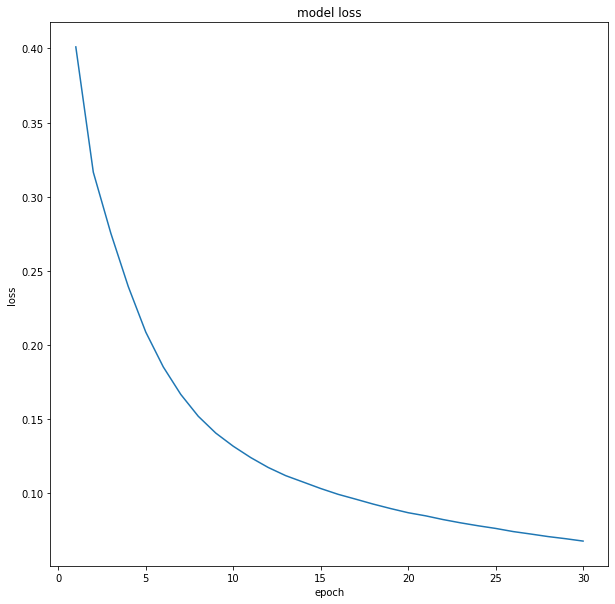

In [44]:
# visualizando a convergência da rede durante o treinamento

plt.figure(figsize = (10,10))
sns.lineplot(y = history1.history["loss"], x = range(1, len(history1.history["loss"]) + 1))
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
def metrics_analise(model, X_data, y_data):
    ypred = model.predict(X_data)
    ypred = np.expm1(ypred)
    y_data = np.expm1(y_data)

    return round(mean_absolute_error(y_data,ypred), 2), round(mean_squared_error(y_data,ypred)**0.5, 2), round(mean_squared_log_error(y_data,ypred), 2)

faixa = 5
dict_resultados = {}
i = 0
while i < 250:
    teste_analise = price_range(teste, i, i + faixa)
    teste_analise, vec_teste, vec, ohe_teste, ohe, x_teste = feature_eng(teste_analise, vec=vec, ohe=ohe)
    yteste = teste_analise["price"]
    yteste = np.log1p(yteste)
    dict_resultados[f'{i} até {i+faixa}'] = metrics_analise(model, x_teste, yteste) + (len(teste_analise),)
    i = i + faixa

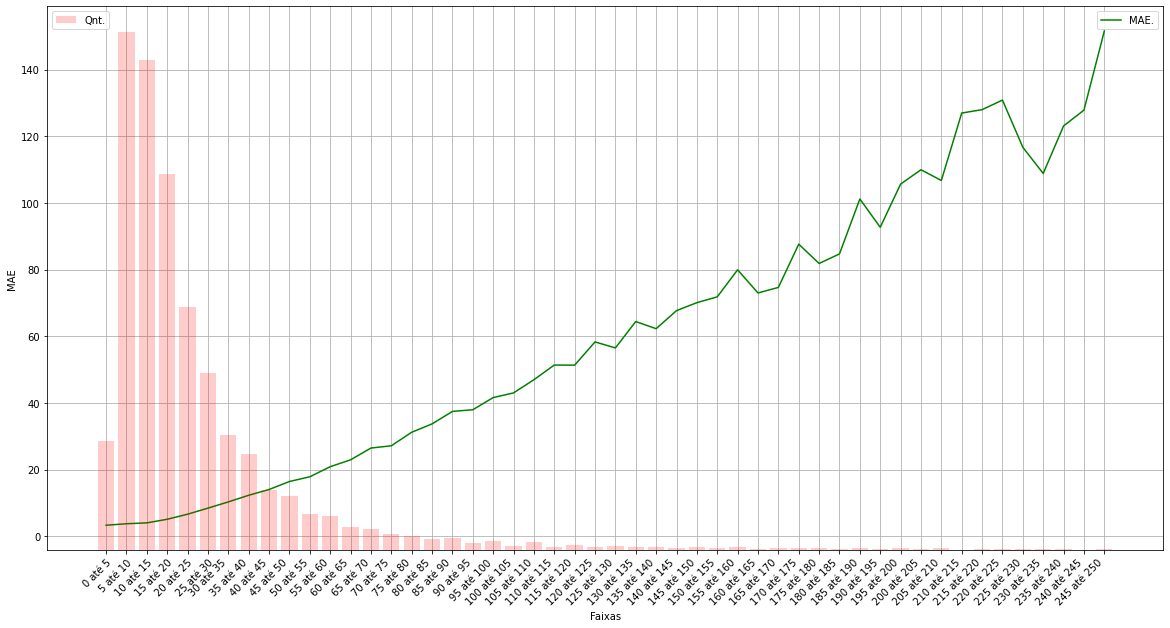

In [177]:


fig1, ax1 = plt.subplots(figsize = (20,10))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.grid()

ax2 = ax1.twinx()
ax1.plot(dict_resultados.keys(), [i[0] for i in dict_resultados.values()], label='MAE.', c='g')
ax1.set_xlabel('Faixas')
ax1.set_ylabel("MAE")
ax1.legend(loc='upper right')

ax2.bar(dict_resultados.keys(), [i[3] for i in dict_resultados.values()], label='Qnt.', color = 'r', alpha= 0.2)
ax2.set_ylabel("Qtd.")
ax2.legend(loc='upper left')
ax2.axis('off')

plt.show()